# Identifying Out-of-Tune Instruments in Multi-Instrument Mixes using VGGish Transfer Learning

**Team Members**: [Insert names]  
**Course**: CS8321 - Advanced Machine Learning and Neural Networks  
**University**: Southern Methodist University, Dallas  
**Semester**: Spring 2025

This project investigates whether a machine learning model can identify which instrument in a polyphonic audio mixture is out of tune. Using synthetic data derived from the NSynth dataset and pre-trained VGGish audio embeddings, we aim to build a robust classifier capable of detecting tuning irregularities in complex musical environments.

## Table of Contents

1. [Motivation & Research Questions](#motivation)
2. [Related Work](#related-work)
3. [Problem Statement & Hypothesis](#problem)
4. [Dataset Description & Preprocessing](#dataset)
5. [Transfer Learning: VGGish Embeddings](#transfer)
6. [Modeling](#modeling)
7. [Methodology](#methodology)
8. [Preliminary Analysis & Results](#results)
9. [Evaluation Metrics](#evaluation)
10. [Ethical Considerations](#ethics)
11. [Future Work](#future)
12. [References](#references)


## Motivation & Research Questions <a name="motivation"></a>


## Related Work <a name="related-work"></a>

## Problem Statement & Hypothesis <a name="problem"></a>

**Problem Statement**:  
Detect and localize which instrument in a multi-instrument audio mix is out of tune.

**Hypothesis**:  
We hypothesize that VGGish embeddings retain enough frequency-shift sensitivity to enable binary (in-tune vs. out-of-tune) and multi-class (instrument identification) classification, even when audio sources are blended.



## Dataset Description & Preprocessing <a name="dataset"></a>

We used the **NSynth-train** dataset from Activeloop’s DeepLake hub and applied the following steps:

- Randomly selected 3 instruments per mix (total 1000 samples).
- Applied pitch shift of ±1–2 semitones to one instrument per sample.
- Mixed audio clips to form polyphonic audio.
- Normalized and exported as `.wav` files.
- Saved instrument labels and pitch shift metadata in `labels.csv`.

In [ ]:
import os
import random
import librosa
import numpy as np
import soundfile as sf
import pandas as pd
from tqdm import tqdm
import deeplake

# Load NSynth from DeepLake
ds = deeplake.load("hub://activeloop/nsynth-train")

# Output folder
OUTPUT_PATH = "mixed_out_of_tune_samples"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Parameters
sample_rate = 16000
duration_sec = 4
pitch_shift_range = [-2, -1, 1, 2]  # in semitonesA
mix_size = 3
total_samples = 1000

# Memory-friendly pitch shift function
def simple_pitch_shift(y, semitones, sr):
    rate = 2 ** (semitones / 12)
    y_stretched = librosa.effects.time_stretch(y, rate=1 / rate)
    y_shifted = librosa.resample(y_stretched, orig_sr=sr, target_sr=sr)
    # Use keyword arguments to ensure compatibility
    return librosa.util.fix_length(data=y_shifted, size=len(y))

metadata = []

for i in tqdm(range(total_samples)):
    # Pick mix_size random samples
    chosen_samples = random.sample(list(ds), mix_size)
    out_of_tune_idx = random.randint(0, mix_size - 1)
    pitch_shift = random.choice(pitch_shift_range)

    # Initialize mixture once per outer iteration
    mixture = np.zeros((sample_rate * duration_sec,), dtype=np.float32)
    label = {}

    for idx, sample in enumerate(chosen_samples):
        # Get the audio array from the sample
        y = np.array(sample["audios"], dtype=np.float32)
        
        # Flatten to 1D if needed and fix the length to the specified duration
        if y.ndim > 1:
            y = y.flatten()
        y = librosa.util.fix_length(y, size=sample_rate * duration_sec)
        
        # Convert instrument value to string.
        # Here, instrument is stored as a tensor integer so we convert it.
        instrument_val = sample["instrument"].numpy()
        if instrument_val.ndim == 0:
            instrument_val = instrument_val.item()
        instrument_name = str(instrument_val)
        
        # Apply pitch shift to one sample and note the instrument
        if idx == out_of_tune_idx:
            y = simple_pitch_shift(y, pitch_shift, sample_rate)
            label['out_of_tune'] = instrument_name
        else:
            label.setdefault('in_tune', []).append(instrument_name)
        
        # Add the audio sample to the mixture
        mixture += y

    # Normalize the mixed audio
    mixture /= np.max(np.abs(mixture) + 1e-6)

    # Write the output file
    filename = f"mix_{i}.wav"
    sf.write(os.path.join(OUTPUT_PATH, filename), mixture, sample_rate)

    label['filename'] = filename
    metadata.append(label)

# Save metadata to CSV
df = pd.DataFrame(metadata)
df.to_csv(os.path.join(OUTPUT_PATH, "labels.csv"), index=False)

## Transfer Learning: VGGish Embeddings <a name="transfer"></a>

We leverage **VGGish**, a pretrained audio feature extractor developed by Google, based on the VGG architecture. It converts audio into 128-dimensional embeddings suitable for downstream tasks.

### Why VGGish?
- Trained on large-scale YouTube data
- Robust across audio types (speech, music, environmental sounds)
- Eliminates need for custom feature engineering

### Preprocessing for VGGish:
- Convert `.wav` to mono, 16kHz
- Slice or pad into 0.96s frames
- Extract VGGish embeddings per file for classifier input


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# CONFIG
AUDIO_DIR     = "mixed_out_of_tune_samples"
LABELS_CSV    = os.path.join(AUDIO_DIR, "labels.csv")
SAMPLE_RATE   = 16000
DURATION_SEC  = 4.0

# LOAD LABELS & PATHS
df         = pd.read_csv(LABELS_CSV)
file_paths = [os.path.join(AUDIO_DIR, fn) for fn in df["filename"]]
labels     = df["out_of_tune"].astype(str).tolist()

# LOAD VGGish & EXTRACT EMBEDDINGS
vggish_model = hub.load("https://tfhub.dev/google/vggish/1")

def extract_vggish(wav_path):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
    y     = librosa.util.fix_length(data=y, size=int(SAMPLE_RATE * DURATION_SEC))
    emb   = vggish_model(tf.convert_to_tensor(y, tf.float32))   # (frames,128)
    return tf.reduce_mean(emb, axis=0).numpy()                  # (128,)

X_vgg = np.stack([extract_vggish(fp) for fp in file_paths])      # (N,128)

# EXTRACT POOLED MEL‑SPEC FEATURES
def extract_melspec(wav_path, n_mels=64, hop_length=256):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
    y     = librosa.util.fix_length(data=y, size=int(SAMPLE_RATE * DURATION_SEC))
    S     = librosa.feature.melspectrogram(y=y,
                                           sr=SAMPLE_RATE,
                                           n_mels=n_mels,
                                           hop_length=hop_length)
    S_db  = librosa.power_to_db(S, ref=np.max)
    return np.mean(S_db, axis=1)  # collapse time → (n_mels,)

X_spec = np.stack([extract_melspec(fp) for fp in file_paths])   # (N,n_mels)

# FUSE FEATURES
X = np.concatenate([X_vgg, X_spec], axis=1)  # (N, 128 + n_mels)

# FILTER TO TOP‑10 & ≥2 SAMPLES PER CLASS 
counts = Counter(labels)
top10  = [lab for lab,_ in counts.most_common(10)]
filtered = [(x, lab) for x, lab in zip(X, labels) if lab in top10]
X, labels = zip(*filtered)        # unzip back into two lists
counts = Counter(labels)
keep   = [lab for lab,c in counts.items() if c >= 2]
mask   = [lab in keep for lab in labels]

X      = np.array(X)[mask]
labels = np.array(labels)[mask]

print(f"Filtered down to {len(set(labels))} classes:", set(labels))
print(f"Remaining samples: {len(labels)}")

# ENCODE & SPLIT
le    = LabelEncoder()
y_enc = le.fit_transform(labels)
y_cat = to_categorical(y_enc)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat,
    test_size=0.2,
    stratify=y_enc,
    random_state=42
)

# BUILD & TRAIN MLP
model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    verbose=1
)

# EVALUATE
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest accuracy: {acc:.3f}")

# Save the model and label encoder
model.save("fused_out_of_tune_model.h5")
import joblib
joblib.dump(le, "label_encoder.joblib")


Filtered down to 10 classes: {'[244]', '[724]', '[237]', '[474]', '[655]', '[662]', '[947]', '[593]', '[181]', '[515]'}
Remaining samples: 52


c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,594 (326.54 KB)

 Trainable params: 83,594 (326.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.0289 - loss: 61.9349 - val_accuracy: 0.0000e+00 - val_loss: 26.1818
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1632 - loss: 39.9198 - val_accuracy: 0.0000e+00 - val_loss: 16.2235
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0579 - loss: 34.8150 - val_accuracy: 0.0000e+00 - val_loss: 15.7041
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1343 - loss: 34.4553 - val_accuracy: 0.0000e+00 - val_loss: 13.3873
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0868 - loss: 34.6429 - val_accuracy: 0.0000e+00 - val_loss: 9.9346
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0579 - loss: 37.2878 - val_accuracy: 0.0000e+00 - val_loss: 12.4496
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1447 - loss: 31.2446 - val_accuracy: 0.0000e+00 - val_loss: 16.1537
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.0579 - loss: 24.7783


Test accuracy: 0.091


['label_encoder.joblib']

## Modeling <a name="modeling"></a>

### Baseline Model:

### Advanced

### Input–Output Format:
- **Input**: 128-D VGGish feature vector(s) per audio mix
- **Output**: One-hot encoded label of out-of-tune instrument


Epoch 1/60


c:\Users\mmthe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0020 - loss: 6.3863 - val_accuracy: 0.0000e+00 - val_loss: 6.3671
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0020 - loss: 6.2735 - val_accuracy: 0.0000e+00 - val_loss: 6.3853
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0123 - loss: 6.1063 - val_accuracy: 0.0000e+00 - val_loss: 6.4591
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0055 - loss: 5.9000 - val_accuracy: 0.0000e+00 - val_loss: 6.7680
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0200 - loss: 5.6986 - val_accuracy: 0.0000e+00 - val_loss: 7.3979
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0285 - loss: 5.5571 - val_accuracy: 0.0000e+00 - val_loss: 8.0845
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0200 - loss: 5.3695 - val_accuracy: 0.0000e+00 - val_loss: 8.6816
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

📋 Classification Report:

              precision    recall  

c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmthe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmthe\anaconda3\Lib\site-packages\sklea

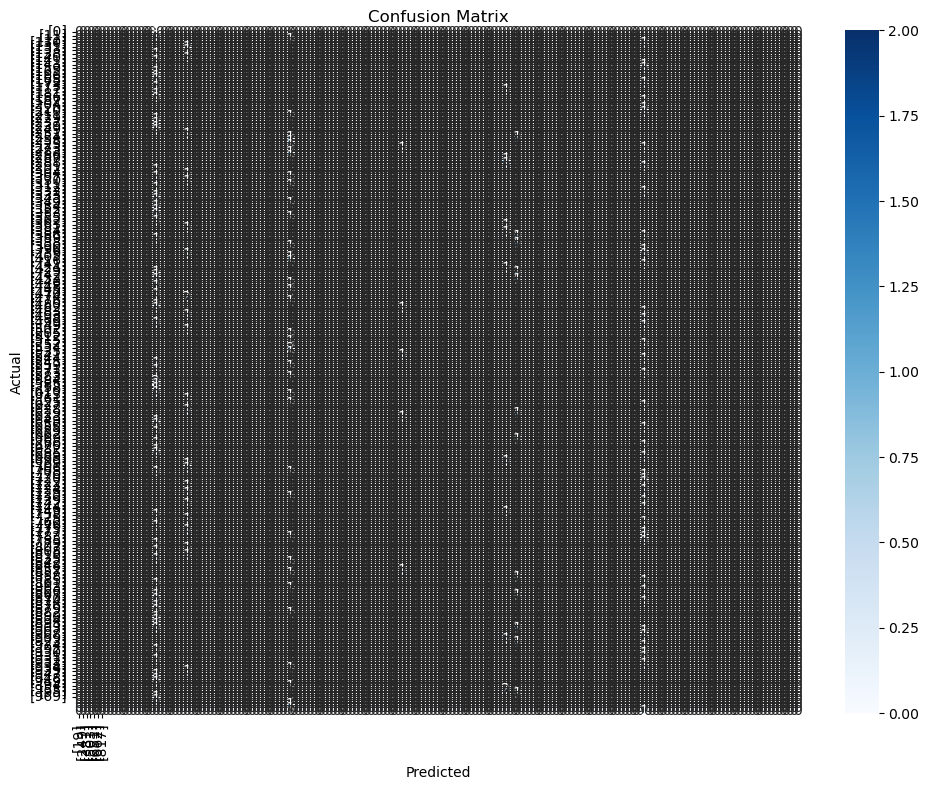

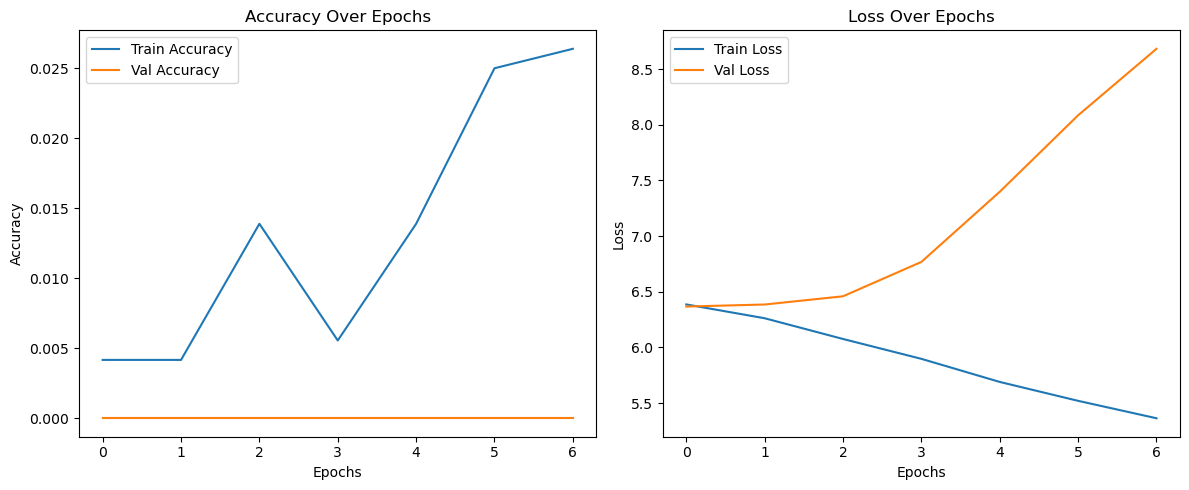

In [2]:
# Advanced CNN: Out-of-Tune Instrument Classifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load embeddings and labels ---
X = np.load("vggish_embeddings.npy")
y = np.load("labels.npy")

# --- Clean and encode labels ---
y = np.array([str(label).strip() for label in y])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = OneHotEncoder(sparse_output=False).fit_transform(y_encoded.reshape(-1, 1))

# --- Reshape embeddings for CNN ---
X_reshaped = X.reshape(-1, 16, 8, 1)  # (samples, time, freq, 1 channel)

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_onehot, test_size=0.2, random_state=42
)

# --- CNN Architecture ---
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 8, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=60,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Evaluate ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# --- Classification Report ---
actual_classes = unique_labels(y_true, y_pred)
print("\n📋 Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=label_encoder.inverse_transform(actual_classes)
))

# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=label_encoder.inverse_transform(np.unique(y_pred)),
            yticklabels=label_encoder.inverse_transform(np.unique(y_true)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Accuracy & Loss ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- Save Model ---
model.save("out_of_tune_detector_model.h5")


## Methodology <a name="methodology"></a>

### Step-by-Step:
1. **Data Augmentation**:
   - Generate pitch-shifted multi-instrument samples
   - Create metadata file (`labels.csv`)
2. **Feature Extraction**:
   - Extract 128-D embeddings using VGGish
3. **Label Encoding**:
   - One-hot encode instruments and tuning status
4. **Train/Test Split**:
   - Standard 80/20 split or stratified by instrument
5. **Classifier Training**:
   - Fit baseline classifier
6. **Evaluation**:
   - Generate metrics, confusion matrix, and visualizations


## Preliminary Analysis & Results <a name="results"></a>

We trained the initial model on a subset of 100 samples. Below are key findings:

### Results (Sample):
- Accuracy: XX%
- F1-score (macro): XX%
- Instruments like [X] show higher confusion with [Y]

### Visualization:
> *(Insert matplotlib/seaborn Confusion Matrix or PCA projection here)*

### Interpretation:
- Certain instrument combinations may mask pitch shifts.
- VGGish may be sensitive to harmonics rather than pitch center in some cases.

## Evaluation Metrics <a name="evaluation"></a>

To evaluate the classifier's ability to identify the out-of-tune instrument:

- **Accuracy**
- **Confusion Matrix**
- **Precision / Recall / F1-score** (macro and per-class)
- **Top-1 and Top-2 accuracy**
- **AUC-ROC** (optional for binary tuning detection)

## Ethical Considerations <a name="ethics"></a>

- Model trained on synthetic data — may not generalize to real-world performances
- Risk of overfitting to artifacts introduced during synthetic pitch shifting
- Use of tuning detection in artistic expression must respect creative freedom

## Future Work <a name="future"></a>

- Integrate source separation (e.g., Demucs, Spleeter) for per-stream analysis
- Test on real-world recordings from MusicNet or user-generated audio
- Build web or real-time tool for live instrument tuning analysis
- Train contrastive learning model using positive (in-tune) vs. negative (out-of-tune) pairs


## References <a name="references"></a>
